In [94]:
import pandas as pd
import calculate
import cars
import matplotlib.pyplot as plt
import numpy as np
from calculate import gini

START_YEAR = 1970
LAST_START_YEAR = 2000

In [95]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Load data from csv

In [96]:
authorCitationsData = pd.read_csv('derived-data/authors-perYear-citations.csv')
authorCitationsData.rename(columns={'year_cit':'year', 'cit_count':'num_cit'}, inplace=True)

In [97]:
authorCitationsData.head()

,author,year,num_cit
0,'maseka lesaoana,2002,1
1,'maseka lesaoana,2003,1
2,'maseka lesaoana,2004,1
3,'maseka lesaoana,2005,2
4,'maseka lesaoana,2006,4


In [98]:
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-extended.csv')

In [99]:
authorStartEndCareerData.head()

,author,start_year,end_year,total_num_pub,career_length,max_absence-0-15,avg_absence-0-15,dropped_after_10,gender,h5_index_max_3,...,early_career_prod_7,early_career_prod_9,early_career_prod_11,early_career_prod_12,early_career_coauthor_max_hindex_3,early_career_coauthor_max_hindex_5,early_career_coauthor_max_hindex_7,early_career_coauthor_max_hindex_9,early_career_coauthor_max_hindex_11,early_career_coauthor_max_hindex_12
0,'maseka lesaoana,2001,2015,2,15,14,5.0,True,none,78.0,...,1,1,1,1,6.0,6.0,6.0,6.0,6.0,6.0
1,(max) zong-ming cheng,2009,2011,2,3,13,5.0,True,none,165.0,...,2,2,2,2,5.0,5.0,5.0,5.0,5.0,5.0
2,(zhou) bryan bai,2011,2012,2,2,14,5.0,True,none,28.0,...,2,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0
3,a aart blokhuis,1992,2005,2,14,13,5.0,True,none,48.0,...,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
4,a ahrabian,2017,2017,1,1,15,7.5,True,none,0.0,...,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
authorPublicationData = pd.read_csv('derived-data/author-publications.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count().reset_index()
author_year_numPub = author_year_numPub.rename(columns={'pub_id':'num_pub'})

In [101]:
authorPublicationData.head()

,author,year,pub_id
0,graeme earl,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
1,gareth beale,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821
2,m. nasser,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
3,faisal zaman,2009,001c8744-73c4-4b04-9364-22d31a10dbf1
4,altaf hossain,2009,001c8744-73c4-4b04-9364-22d31a10dbf1


Load in citation window data:

In [102]:
WINDOW_SIZE = 3
citations_window = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv')
citations_window.head()

,year,author,start_year,end_year,gender,career_age,num_pub,num_cit,career_duration,win_num_pub,...,ec_cit_6_9,ec_cit_0_1,ec_cit_3_4,ec_cit_6_7,ec_cit_0_3_cum,ec_cit_3_6_cum,ec_cit_6_9_cum,ec_cit_0_1_cum,ec_cit_3_4_cum,ec_cit_6_7_cum
0,1970,v. a. abell,1970,1970,none,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1970,a. e. brenner,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1970,l. g. mitten,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1970,w. schwering,1970,1970,none,1,2.0,1.0,1,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1970,charles m. eastman,1970,2016,m,1,1.0,0.0,47,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# citations_window[citations_window['author'] == 'ke xu']

Create counts table:

In [104]:
counts = citations_window

In [105]:
years = authorStartEndCareerData['start_year'].unique()
years = sorted(years)

cohort_start_years = [year for year in years if year>=START_YEAR and year<= LAST_START_YEAR]

Is this how it's done in the other analyses?

Do this only if interested in cohorts:

In [106]:
#counts = counts[counts['year'] <= counts['end_year']]

## Cohort Sizes

In [107]:
cohort_sizes = counts.groupby('start_year').agg({'author': 'nunique'})

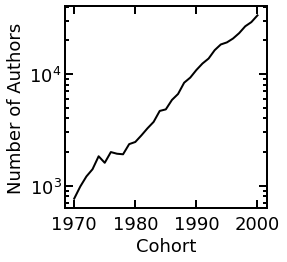

In [308]:
linewidth = 2
fontsize = 18
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(cohort_sizes.index, cohort_sizes.values, linewidth=linewidth, color='black')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_yscale('log')
ax.set_xlabel('Cohort', fontsize=fontsize)
ax.set_ylabel('Number of Authors', fontsize=fontsize)
#ax.set_title('', fontsize=fontsize)
ax.set_xticks([1970, 1980, 1990, 2000])
ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax.spines['left'].set_linewidth(linewidth)
ax.spines['right'].set_linewidth(linewidth)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['top'].set_linewidth(linewidth)
#ax.legend(fontsize=fontsize)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
fig.savefig('./fig-7-notebook/cohort_size.pdf')

## Ginis

#### Cumulative

Reproduction of Claudia's figure 2:

In [231]:
cohort_counts_gini = citations_window.groupby(['start_year', 'career_age']).agg({
    'cum_num_pub':gini, 'cum_num_cit':gini, 'win_num_pub':gini, 'cit_3':gini}).reset_index()

In [232]:
cohort_counts_gini = cohort_counts_gini.rename({
    'cum_num_pub':'gini_cum_num_pub', 
    'cum_num_cit':'gini_cum_num_cit',
    'win_num_pub':'gini_win_num_pub',
    'cit_3': 'gini_win_num_cit'
}, axis='columns')

In [234]:
cohort_counts_gini.loc[cohort_counts_gini['career_age'] > 13, 'gini_win_num_cit'] = np.nan
cohort_counts_gini

,start_year,career_age,gini_cum_num_pub,gini_cum_num_cit,gini_win_num_pub,gini_win_num_cit
0,1970,1,0.078832,0.945726,0.262986,0.789937
1,1970,2,0.169304,0.863494,0.845134,0.974083
2,1970,3,0.262986,0.803480,0.837125,0.948333
3,1970,4,0.318189,0.786051,0.842827,0.960702
4,1970,5,0.368805,0.780465,0.859183,0.966079
5,1970,6,0.410486,0.785341,0.872545,0.972540
6,1970,7,0.442170,0.788976,0.880887,0.978756
7,1970,8,0.467626,0.795581,0.885004,0.959909
8,1970,9,0.488080,0.806726,0.894921,0.971045
9,1970,10,0.506134,0.810233,0.896559,0.973009


In [280]:
def plot_gini_over_career_ages(criteria, criteria_name, title, letter, data=cohort_counts_gini, y_start=0, x_start=1, x_end=16):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    color = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    cohort = [1970, 1975, 1980, 1985, 1990, 1995, 2000]
    for i in range(0, 7):
        df = data[data['start_year'] == cohort[i]]
        df = df[df['career_age'] >= x_start]
        ax.plot(df['career_age'], df[criteria], linewidth=linewidth, label=cohort[i], color=color[i])
    ax.set_xlim([0.25, 15.75])
    ax.set_ylim([-0.05, 1.05])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel('Career Age', fontsize=fontsize)
    ax.set_ylabel(f'Gini {criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks([1, 5, 10, 15])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    ax.legend(fontsize=fontsize/2)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig-7-notebook/{criteria}.pdf')

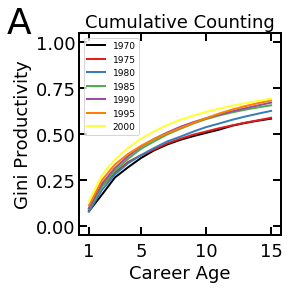

In [253]:
plot_gini_over_career_ages('gini_cum_num_pub', 'Productivity', 'Cumulative Counting', 'A')

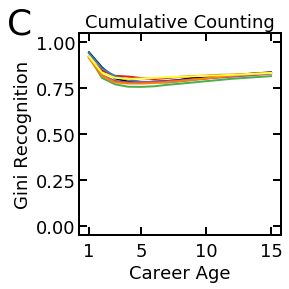

In [255]:
plot_gini_over_career_ages('gini_cum_num_cit', 'Recognition', 'Cumulative Counting', 'C')

#### Time Windows

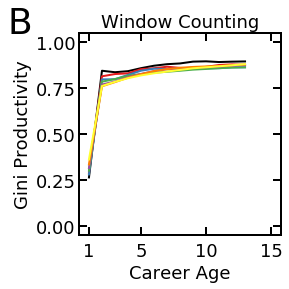

In [256]:
plot_gini_over_career_ages('gini_win_num_pub', 'Productivity', 'Window Counting', 'B')

For recognition the data can't be produced like for productivity, because a window must not contain the number of citations received within the time window, but the number of citations made within the window to papers produced in the window:

In [121]:
citations_window.head()

,year,author,start_year,end_year,gender,career_age,num_pub,num_cit,career_duration,win_num_pub,...,ec_cit_6_9,ec_cit_0_1,ec_cit_3_4,ec_cit_6_7,ec_cit_0_3_cum,ec_cit_3_6_cum,ec_cit_6_9_cum,ec_cit_0_1_cum,ec_cit_3_4_cum,ec_cit_6_7_cum
0,1970,v. a. abell,1970,1970,none,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1970,a. e. brenner,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1970,l. g. mitten,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1970,w. schwering,1970,1970,none,1,2.0,1.0,1,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1970,charles m. eastman,1970,2016,m,1,1.0,0.0,47,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


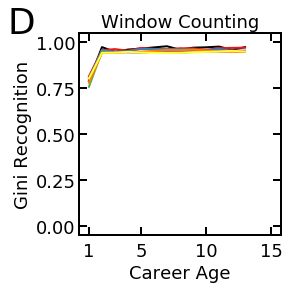

In [257]:
plot_gini_over_career_ages('gini_win_num_cit', 'Recognition', 'Window Counting', 'D')

#### Inequality of early vs later work

In [128]:
citations_window.head()

,year,author,start_year,end_year,gender,career_age,num_pub,num_cit,career_duration,win_num_pub,...,ec_cit_6_9,ec_cit_0_1,ec_cit_3_4,ec_cit_6_7,ec_cit_0_3_cum,ec_cit_3_6_cum,ec_cit_6_9_cum,ec_cit_0_1_cum,ec_cit_3_4_cum,ec_cit_6_7_cum
0,1970,v. a. abell,1970,1970,none,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1970,a. e. brenner,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1970,l. g. mitten,1970,1970,m,1,1.0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1970,w. schwering,1970,1970,none,1,2.0,1.0,1,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1970,charles m. eastman,1970,2016,m,1,1.0,0.0,47,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]

aggregate = {f'ec_cit_{start}_{end}': gini for start,end in publish_years}
aggregate.update({f'ec_cit_{start}_{end}_cum': gini for start,end in publish_years})

author_gini_early_work = citations_window.groupby(['start_year', 'career_age']).agg(aggregate).reset_index()

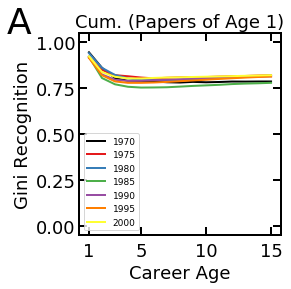

In [297]:
start = 0
end = 1
plot_gini_over_career_ages(f'ec_cit_{start}_{end}_cum', 'Recognition', 
    title=f'Cum. (Papers of Age {start+1})', 
    letter='A', 
    data=author_gini_early_work)

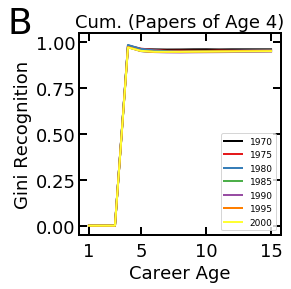

In [298]:
start = 3
end = 4
plot_gini_over_career_ages(f'ec_cit_{start}_{end}_cum', 'Recognition', 
    title=f'Cum. (Papers of Age {start+1})', 
    letter='B', 
    data=author_gini_early_work)

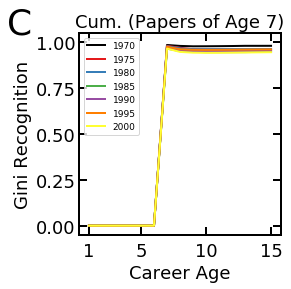

In [299]:
start = 6
end = 7
plot_gini_over_career_ages(f'ec_cit_{start}_{end}_cum', 'Recognition', 
    title=f'Cum. (Papers of Age {start+1})', 
    letter='C', 
    data=author_gini_early_work)

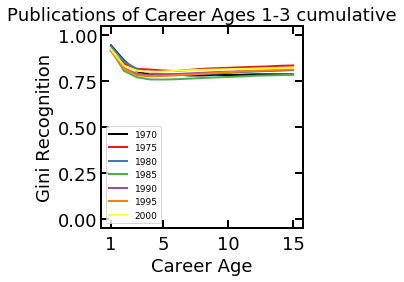

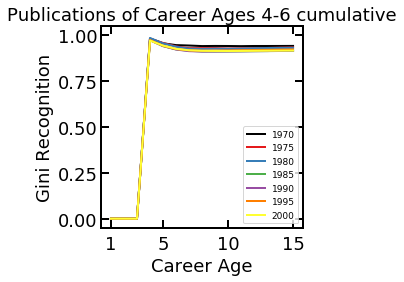

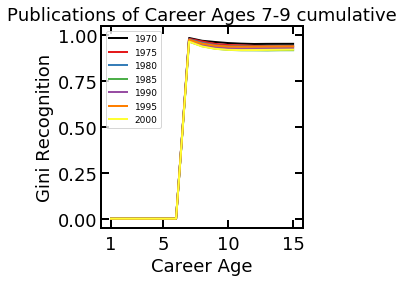

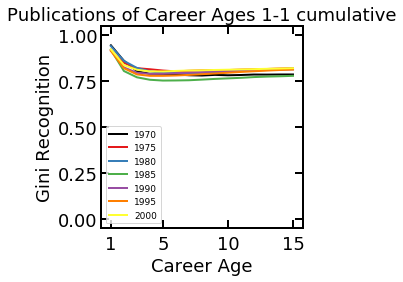

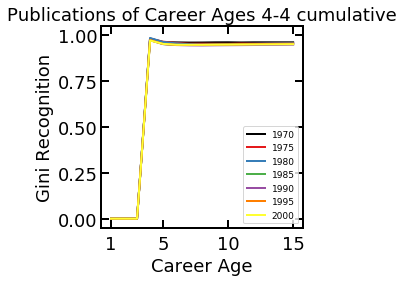

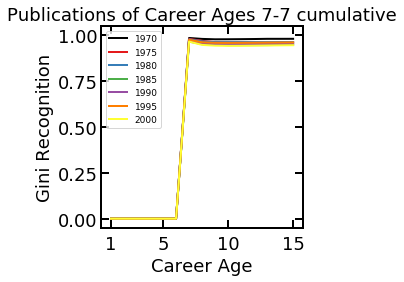

In [301]:
#cumulative
# TODO remove data, keep axis
for start,end in publish_years:
    plot_gini_over_career_ages(f'ec_cit_{start}_{end}_cum', 'Recognition', 
                               title=f'Publications of Career Ages {start+1}-{end} cumulative', 
                               letter='', 
                               data=author_gini_early_work)

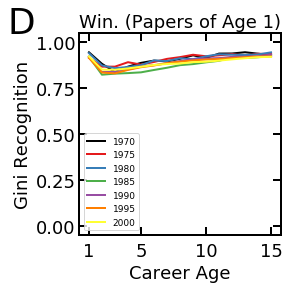

In [305]:
start = 0
end = 1
plot_gini_over_career_ages(f'ec_cit_{start}_{end}', 'Recognition', 
    title=f'Win. (Papers of Age {start+1})', 
    letter='D', 
    data=author_gini_early_work)

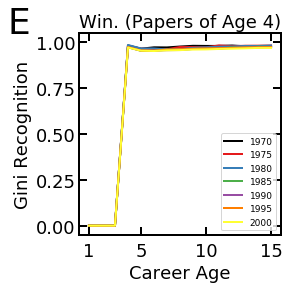

In [306]:
start = 3
end = 4
plot_gini_over_career_ages(f'ec_cit_{start}_{end}', 'Recognition', 
    title=f'Win. (Papers of Age {start+1})', 
    letter='E', 
    data=author_gini_early_work)

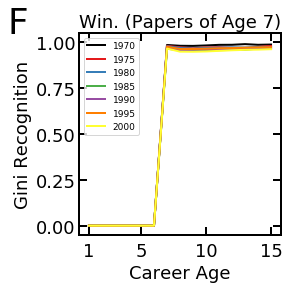

In [307]:
start = 6
end = 7
plot_gini_over_career_ages(f'ec_cit_{start}_{end}', 'Recognition', 
    title=f'Win. (Papers of Age {start+1})', 
    letter='F', 
    data=author_gini_early_work)

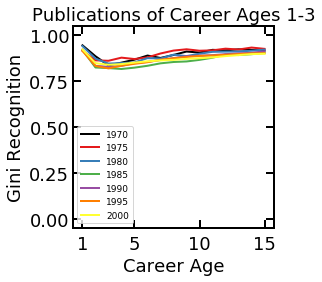

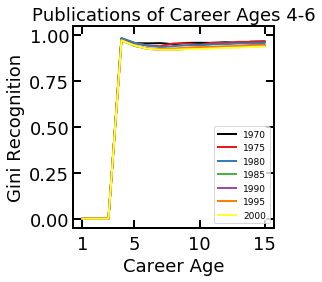

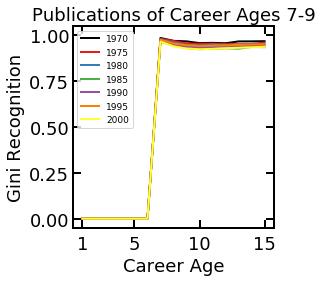

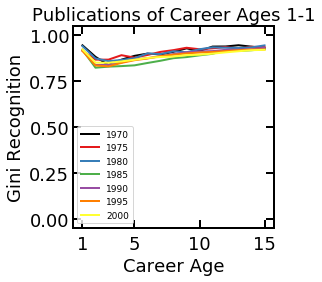

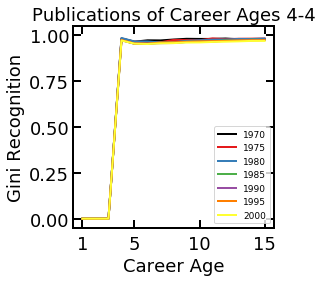

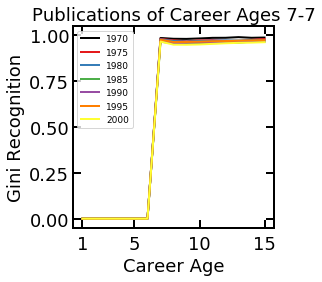

In [303]:
#non cumulative
for start,end in publish_years:
    plot_gini_over_career_ages(f'ec_cit_{start}_{end}', 'Recognition', 
                               title=f'Publications of Career Ages {start+1}-{end}', 
                               letter='', 
                               data=author_gini_early_work)

In [132]:
lax

NameError: name 'lax' is not defined

## Distributions

### Cohort Years
Cumulative numbers needed.

In [ ]:
start_year = 2000
career_age = 15
data = counts[(counts['start_year'] == start_year) & (counts['career_age'] == career_age)]['cum_num_pub']
data = data[data > 0]
#np.median(data)
#np.round(np.mean(data))

In [ ]:
# pdf='cum_num_pub_2000.pdf'
cars.fit_univariate(data, discrete=True, xmin=1, xlabel='p', title='2000', bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=24, unbinned_data=True, pdf=None, png=None)

In [ ]:
#guys from 2000 cohort with more than 300 papers
counts[(counts['start_year'] == 2000) & (counts['career_age'] == 15) & (counts['cum_num_pub'] > 300)][['author', 'cum_num_pub']]

### Years

In [ ]:
year = 2014
p = counts[counts['year'] == year]['cum_num_pub']
p = p[p > 0]
#np.median(p)
#np.round(np.mean(p))

In [ ]:
# pdf='years_cum_num_pub_2014.pdf'
cars.fit_univariate(p, discrete=True, xmin=1, xlabel='p', title=None, bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='years_cum_num_pub_2014.pdf', png='years_cum_num_pub_2014.png')

In [ ]:
pubids = authorPublicationData.pub_id.tolist()

In [ ]:
df_citations = pd.read_csv('data/paper_venue_citations.csv', sep='\t')

In [ ]:
df_citations = df_citations[df_citations.year.between(1970, 2014)]
df_citations = df_citations[df_citations.paper2.isin(pubids)]

In [ ]:
c = df_citations.groupby(['venue2']).size()

In [ ]:
### pdf='years_cum_num_cit_2014.pdf'
cars.fit_univariate(c, discrete=True, xmin=(1, 10), xlabel='c', title=None, bins=24, bootstrap=None, col=2, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='bradford_2014.pdf', png='bradford_2014.png')

## Matthew Effect

In [ ]:
# prepare output tables
micro_stats = pd.DataFrame(columns=['t', 'dt', 'author', 'eta'])
macro_stats = pd.DataFrame(columns=['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi'])
# settings
dt = 5
unit = 'num_cit' # CHANGE COLOR (1) AND LETTER (5)
fit = 'odr'
for t in range(1970+dt, 2015-dt+2): # range(1975, 2012) for dt=5
    # get vectors
    t0 = counts[counts['year'].between(t-dt, t-1)][['author', unit]].groupby('author').sum()
    t1 = counts[counts['year'].between(t, t+dt-1)][['author', unit]].groupby('author').sum()
    #t1 = counts[counts['year'].between(t, t)][['author', unit]].groupby('author').sum()
    t0 = t0[t0[unit] > 0]
    t1 = t1[t1[unit] > 0]
    # merge vectors into dataframe
    ca = pd.merge(left=t0, right=t1, left_index=True, right_index=True)
    ca.columns = ['t0', 't1']
    # fit
    df_stats, df_bootstrap = cars.fit_bivariate(ca['t0'], ca['t1'], fit=fit, reduction='bin', color=2, xlabel='c_{%.0f-%.0f}' %(t-dt, t-1), ylabel='c_{%.0f-%.0f}' %(t, t+dt-1), title='', pdf='matthew/macro_c_'+fit+'Bin_t'+str(t)+'_dt'+str(dt)+'.pdf')
    # extend micro stats (fitness)
    ca['t'] = t
    ca['dt'] = dt
    ca['author'] = ca.index
    t1_exp = df_stats['D'][0]*ca['t0']**df_stats['beta'][0]
    ca['eta'] = ca['t1']/t1_exp
    ca = ca[['t', 'dt', 'author', 'eta']]
    # extend macro stats
    df_stats['t'] = t
    df_stats['dt'] = dt
    df_stats = df_stats[['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi']]
    # append stats
    micro_stats = pd.concat([micro_stats, ca], axis=0, ignore_index=True)
    macro_stats = pd.concat([macro_stats, df_stats], axis=0, ignore_index=True)
# write output tables
micro_stats.to_csv('matthew/micro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)
macro_stats.to_csv('matthew/macro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)

### Cumulative Advantage

In [ ]:
macro_p_olsBin_dt5 = pd.read_csv('matthew/macro_p_olsBin_dt5.txt', sep='\t')
macro_c_olsBin_dt5 = pd.read_csv('matthew/macro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
macro_p_odrBin_dt5 = pd.read_csv('matthew/macro_p_odrBin_dt5.txt', sep='\t')
macro_c_odrBin_dt5 = pd.read_csv('matthew/macro_c_odrBin_dt5.txt', sep='\t')

In [ ]:
plt.fill_between(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta']-macro_p_olsBin_dt5['beta_std'], macro_p_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta']-macro_c_olsBin_dt5['beta_std'], macro_c_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Ordinary Least Squares')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

In [ ]:
plt.fill_between(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta']-macro_p_odrBin_dt5['beta_std'], macro_p_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta']-macro_c_odrBin_dt5['beta_std'], macro_c_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Orthogonal Distance Regression')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

### Fitness

In [ ]:
micro_p_olsBin_dt5 = pd.read_csv('matthew/micro_p_olsBin_dt5.txt', sep='\t')
micro_c_olsBin_dt5 = pd.read_csv('matthew/micro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
micro_p_odrBin_dt5 = pd.read_csv('matthew/micro_p_odrBin_dt5.txt', sep='\t')
micro_c_odrBin_dt5 = pd.read_csv('matthew/micro_c_odrBin_dt5.txt', sep='\t')

Users with long careers:

In [ ]:
micro_p_olsBin_dt5.groupby('author').count()

In [ ]:
#author = 'a min tjoa'
#author = 'a-nasser ansari'
#author = 'a-xing zhu'
author = 'a. a. (louis) beex'
#author = 'a. a. agboola'
#author = 'a. a. ball'
#author = 'a. a. el-bary'
#author = 'ülkü gürler'
#author = 'ülle kotta'
#author = 'ülo nurges'
#author = 'ümit aygölü'
#author = 'ümit bilge'
#author = 'ümit güz'
#author = 'ümit v. çatalyürek'
#author = 'ümit y. ogras'
#author = 'ümit özgüner'
#author = 'ünal göktas'
#author = 'ünal ufuktepe'
p = micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == author]
c = micro_c_olsBin_dt5[micro_c_olsBin_dt5['author'] == author]
plt.plot(p['t'], p['eta'], label='Productivity')
plt.plot(c['t'], c['eta'], label='Recognition')
plt.xlabel('Year')
plt.ylabel('Fitness')
plt.legend()

Lognormal fitness distributions:

In [ ]:
etaMean_p_olsBin_dt5 = micro_p_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']
etaMean_c_olsBin_dt5 = micro_c_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']

In [ ]:
print('mean:', np.mean(np.log10(etaMean_p_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_p_olsBin_dt5)))
plt.hist(np.log10(etaMean_p_olsBin_dt5))

In [ ]:
print('mean:', np.mean(np.log10(etaMean_c_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_c_olsBin_dt5)))
plt.hist(np.log10(etaMean_c_olsBin_dt5))

Correlation of productivity and recognition fitness:

In [ ]:
etaMean_olsBin_dt5 = pd.concat([etaMean_p_olsBin_dt5, etaMean_c_olsBin_dt5], axis=1)
etaMean_olsBin_dt5.columns = ['p', 'c']

In [ ]:
etaMean_olsBin_dt5.dropna(inplace=True)

In [ ]:
print('corrcoef:', np.corrcoef(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])[0, 1])
plt.scatter(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Productivity Fitness')
plt.ylabel('Mean Recognition Fitness')

## Variance of Fitness for Cohorts

In [ ]:
counts[counts['author'] == 'a. breton']

In [ ]:
micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == 'a. breton']

In [ ]:
counts_fitness_p = pd.merge(left=counts, right=micro_p_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])
counts_fitness_c = pd.merge(left=counts, right=micro_c_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])

In [ ]:
counts_fitness_p.head()

In [ ]:
counts_fitness_c.head()

Note: eta for 1975 is based on productivity in 1975-1979.

In [ ]:
counts_fitness_p_mean = counts_fitness_p.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_p_mean[counts_fitness_p_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
counts_fitness_c_mean = counts_fitness_c.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_c_mean[counts_fitness_c_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()

On average, scholars have high fitness at the beginning of their career. To which extent is the mean influenced by scholars with long careers? In other wordw, is high fitness in early years a predictor of career duration?

In [ ]:
AB HIER BAUSTELLE

In [ ]:
career_duration = [6, 10]
counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_p_mean['career_age'])

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_p_mean['career_age'], counts_fitness_p_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
career_duration = [6, 10]
counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_c_mean['career_age'])

In [ ]:
counts_fitness_c

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_c_mean['career_age'], counts_fitness_c_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()